In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
ca_tsp = pd.read_csv("CA_TSP.csv")
city_matrix = pd.read_csv("city_matrix.csv")
city_matrix.index = city_matrix["Unnamed: 0"]
city_matrix.drop("Unnamed: 0",axis=1,inplace=True)
city_matrix = city_matrix/10

In [3]:
top_city = np.array(ca_tsp.sort_values("Population",ascending=False).City[:10])
oth_city = np.array(ca_tsp.sort_values("Population",ascending=False).City[10:])
print("top_city",top_city)
print("oth_city",oth_city)

top_city ['Q' 'N' 'X' 'T' 'E' 'D' 'U' 'A' 'R' 'L']
oth_city ['W' 'V' 'O' 'S' 'Y' 'J' 'H' 'P' 'G' 'F' 'B' 'M' 'K' 'I' 'C']


In [4]:
def route_dist(route,city_matrix):
    dist = 0
    for r in range(len(route)):
#         if r != route[0]:
        if r != 0:
            dist = dist + city_matrix.loc[route[r],route[r-1]]
    return dist

In [5]:
def cover_all_city(route_set):
    unlist_parent = [list(i) for i in route_set]
    t = []
    for i in unlist_parent:
        t = t + i
    if len(set(t)) == 25:
        return True
    else:
        return False

In [6]:
def population_covered(route_set,ca_tsp):
    unlist_parent = [list(i) for i in route_set]
    t = []
    for i in unlist_parent:
        t = t + i
    tot_dist = 0
    for city in t:
        tot_dist = tot_dist + ca_tsp.loc[ca_tsp.City == city,"Population"].values[0]
    return tot_dist

In [7]:
def dist_bw_petrol(route,city_matrix,ca_tsp,petrol_max_dist):
    dist = 0
    for r in range(len(route)):
        if r != 0:
            dist = dist + city_matrix.loc[route[r],route[r-1]]
            if dist > petrol_max_dist: break
            if r != len(route)-1 and ca_tsp.loc[ca_tsp.City == route[r],"Has_petrol"].values[0]: dist = 0 
    return dist

In [8]:
# def create_initial_population(city_matrix,ca_tsp,route_num,seed_num,pop_size):
#     initial_pop=[]
# # not intersted in creating parent-1, 
# # can comment next five lines and use range(pop_size) instead of range(pop_size-1)
#     parent1=[]
#     top_city = np.array(ca_tsp.sort_values("Population",ascending=False).City[:route_num])
#     for i in top_city:
#         parent1.append(i+city_matrix[i].sort_values()[1:8].index.values.sum())
#     initial_pop.append(parent1)
#     random.seed(seed_num)
# #     for n in range(pop_size):
#     for n in range(pop_size-1):
#         while True:
#             parent = []
#             for i in top_city:
#                 city_list = list(ca_tsp.City)
#                 city_list.remove(i)
#                 while True:
#                     gen_route = i+np.array(random.sample(set(city_list),7),dtype='object').sum()
#                     if route_dist(gen_route,city_matrix) <= max_dist:
#                         break
#                 parent.append(gen_route)
#             if cover_all_city(parent):
#                 initial_pop.append(parent)
#                 break    
#     return initial_pop

In [9]:
# No fixed city in the first position
def create_initial_population(city_matrix,ca_tsp,route_num,seed_num,pop_size):
    initial_pop=[]
# not intersted in creating parent-1, 
# can comment next five lines and use range(pop_size) instead of range(pop_size-1)
#     parent1=[]
#     top_city = np.array(ca_tsp.sort_values("Population",ascending=False).City[:route_num])
#     for i in top_city:
#         parent1.append(i+city_matrix[i].sort_values()[1:8].index.values.sum())
#     initial_pop.append(parent1)
#     random.seed(seed_num)
    for n in range(pop_size):
#     for n in range(pop_size-1):
        while True:
            parent = []
#             for i in top_city:
            for i in range(route_num):
                city_list = list(ca_tsp.City)
#                 city_list.remove(i)
                while True:
#                     gen_route = i+np.array(random.sample(set(city_list),7),dtype='object').sum()
                    gen_route = np.array(random.sample(set(city_list),8),dtype='object').sum()
                    if route_dist(gen_route,city_matrix) <= max_dist:
                        break
                parent.append(gen_route)
            if cover_all_city(parent):
                initial_pop.append(parent)
                break    
    return initial_pop

In [10]:
def fitness_function(route_set,city_matrix,ca_tsp,petrol_max_dist):
    less_eq_max_dist = True
    for r in route_set:
        if route_dist(r,city_matrix) > max_dist:
            less_eq_max_dist = False
            break    
    dist_travel = [route_dist(route,city_matrix) for route in route_set]
    petrol_dist = [dist_bw_petrol(route,city_matrix,ca_tsp,petrol_max_dist) for route in route_set]   
    if cover_all_city(route_set) and less_eq_max_dist and max(petrol_dist) <= petrol_max_dist:
        fitness = population_covered(route_set,ca_tsp) - round(sum(dist_travel),1)
        return fitness
    else:
        return -10000

In [11]:
# test_city_matrix = city_matrix/10
# test_route_set = ['VYATNRDX', 'NXYRDEPU', 'TOFIKNLC', 'FNXQBWTL', 'EUSGPQXN', 'JXRWQSNV', 'YRNEVGQW', 'BRUXATVI', 'XDRQPYAO', 'RVDHTNMP']
# t = [route_dist(r,test_city_matrix) for r in test_route_set]
# #     if route_dist(r,city_matrix) > max_dist:
# #         less_eq_max_dist = False
# #         break      
# print(t)
# round(sum(t),1)

In [12]:
def inter_crossover(population,pop_size,route_num):
    random.seed(seed_num)
    inter_cross_off = []
#     print(len(population))
    t = random.sample(set(map(tuple,population)),100)
    for i in range(0,pop_size,2):
        #parent1 
        p1_idx = i%pop_size
        #parent2
        p2_idx = (i+1)%pop_size
        cut_pt1 = random.randint(0,5)
        cut_pt2 = cut_pt1 + route_num//2
        inter_off1 = t[p1_idx][0:cut_pt1] + t[p2_idx][cut_pt1:cut_pt2] + t[p1_idx][cut_pt2:]
        inter_off2 = t[p2_idx][0:cut_pt1] + t[p1_idx][cut_pt1:cut_pt2] + t[p2_idx][cut_pt2:]
        inter_cross_off.append(list(inter_off1))
        inter_cross_off.append(list(inter_off2))
    return inter_cross_off

In [13]:
def non_repeat_nodes(route):
    len1 = len(set([i for i in route]))
    if len1 == 8:
        return True
    else:
        return False

In [14]:
def intra_crossover(m,max_nodes):
    intra_cross_off = []
#     m = 3
    for i in (inter_cross_off * m):
        while True:
            t = list(i)
            r = random.sample(range(max_nodes),2)
    #         print(rand_idx)
            temp_route1 = t[r[0]]
    #         print(temp_route1)
            temp_route2 = t[r[1]]
    #         print(temp_route2)
#             cut_pt1 = random.randint(1,4)
            cut_pt1 = random.randint(0,4) # allowing to change the first positioned city as well
    #         print(cut_pt1)
            cut_pt2 = cut_pt1 + max_nodes//2
            temp_route1 = t[r[0]][0:cut_pt1] + t[r[1]][cut_pt1:cut_pt2] + t[r[0]][cut_pt2:]
            temp_route2 = t[r[1]][0:cut_pt1] + t[r[0]][cut_pt1:cut_pt2] + t[r[1]][cut_pt2:]
            if non_repeat_nodes(temp_route1) and non_repeat_nodes(temp_route2):
                t[r[0]] = temp_route1
                t[r[1]] = temp_route2
                intra_cross_off.append(t)
    #             print(t[r[0]])
    #             print(t[r[1]])
                break
    return intra_cross_off

In [15]:
# mutation
def mutation(crossover_offspring,mutation_rate,max_nodes,ca_tsp):
    mutated_offspring = []
    for idx in range(len(crossover_offspring)):
        crossover_offspring[idx] = list(crossover_offspring[idx])
        for gene_num in range(len(crossover_offspring[idx])):
            if random.random() < mutation_rate:
                while True:
#                     mut_pt = random.randint(1,max_nodes-1)
                    mut_pt = random.randint(0,max_nodes-1) # allowing to change the first positioned city as well
                    temp = list(crossover_offspring[idx][gene_num])
                    temp[mut_pt] = random.choice(list(ca_tsp.City))
                    temp = ''.join(temp)
                    if non_repeat_nodes(temp):
                        crossover_offspring[idx][gene_num] = temp
                        break
        mutated_offspring.append(crossover_offspring[idx])    
    return mutated_offspring

In [16]:
def rankroutes(group_population,city_matrix,ca_tsp,petrol_max_dist):
    fitness_results = []
    for i in range(0,len(group_population)):
        route_set = group_population[i]
        fitness_results.append([i,fitness_function(route_set,city_matrix,ca_tsp,petrol_max_dist)])
    fitness_df = pd.DataFrame(fitness_results,columns=["Index","Fitness"])
    fitness_df = fitness_df.sort_values("Fitness",ascending=False)
    return fitness_df

In [17]:
def selection(ranked_fitness,pop_size,group_population):
    new_gen_population = []
    rank_idx = 0
    while len(set(map(tuple,new_gen_population))) < pop_size:
        new_gen_population.append(group_population[ranked_fitness.iloc[rank_idx,0]])
        rank_idx += 1
    return new_gen_population

In [18]:
def ind_fitness_values(route_set,city_matrix,ca_tsp,petrol_max_dist):
    less_eq_max_dist = True
    for r in route_set:
        if route_dist(r,city_matrix) > max_dist:
            less_eq_max_dist = False
            break    
    dist_travel = [route_dist(route,city_matrix) for route in route_set]
    petrol_dist = [dist_bw_petrol(route,city_matrix,ca_tsp,petrol_max_dist) for route in route_set]   
    if cover_all_city(route_set) and less_eq_max_dist and max(petrol_dist) <= petrol_max_dist:
        x = population_covered(route_set,ca_tsp)
        y = round(sum(dist_travel),1)
        fitness = x - y
    else:
        x = population_covered(route_set,ca_tsp)
        y = round(sum(dist_travel),1)
        fitness = -10000
    return fitness,x,y

In [19]:
max_nodes = 8
max_dist = 40
route_num=10
seed_num=143
pop_size=100
m=3
mutation_rate = 0.07
gen = 100
petrol_max_dist = 20.0
population = create_initial_population(city_matrix, ca_tsp, route_num, seed_num, pop_size)
best_route = population[rankroutes(population,city_matrix,ca_tsp,petrol_max_dist).iloc[0,0]]
best_fitness, best_pop, best_dist = ind_fitness_values(best_route,city_matrix,ca_tsp,petrol_max_dist)
# best_fitness = rankroutes(population,city_matrix,ca_tsp,petrol_max_dist).iloc[0,1]
print("Initial best route: " , best_route)
print("Initial best fitness: " , best_fitness)
print("Initial best population: " , best_pop)
print("Initial best distance: " , best_dist)

Initial best route:  ['VHJTAISO', 'DUWYOBCS', 'CIUKAQWV', 'YXGLNBAF', 'FSDGUXJM', 'QHCXRNAK', 'EJMXAIHP', 'RPDWLNOY', 'ICRBFNQS', 'GLAFJXDU']
Initial best fitness:  1890.6
Initial best population:  2219
Initial best distance:  328.4


In [20]:
# adding previous best path with fitness function 3063
# population[0] =  ['QXDWNTOE', 'NSYETQXF', 'XQNETDUB', 'TXQJHNEL', 'EUNCVQXT', 'DLRNTQXU', 'UQNETXID', 'AERNDQXT', 'RXTNPQKM', 'LTGQDEXN']
data = pd.DataFrame([[0, best_route, best_fitness, best_pop, best_dist]],columns=['Generation','Route','Fitness','Population','Distance'])
data

,Generation,Route,Fitness,Population,Distance
0,0,"[VHJTAISO, DUWYOBCS, CIUKAQWV, YXGLNBAF, FSDGU...",1890.6,2219,328.4


In [21]:
gen = 100
for g in range(gen):
    inter_cross_off = inter_crossover(population,pop_size,route_num)
    intra_cross_off = intra_crossover(m,max_nodes)
    crossover_offspring = inter_cross_off + intra_cross_off
    group_population = population + crossover_offspring
    mutated_offspring = mutation(group_population,mutation_rate,max_nodes,ca_tsp)
    group_population = population + mutated_offspring
    ranked_fitness = rankroutes(group_population,city_matrix,ca_tsp,petrol_max_dist)
    new_gen_population = selection(ranked_fitness,pop_size,group_population)
    df_len = len(data)
    best_route = new_gen_population[0]
    #best_fitness = ranked_fitness.iloc[0,1]
    best_fitness, best_pop, best_dist = ind_fitness_values(best_route,city_matrix,ca_tsp,petrol_max_dist)
    data.loc[df_len,'Generation'] = g+1
    data.loc[df_len,'Route'] = str(best_route)
    data.loc[df_len,'Fitness'] = best_fitness
    data.loc[df_len,'Population'] = best_pop
    data.loc[df_len,'Distance'] = best_dist    
    population = list(set(map(tuple,new_gen_population)))

In [ ]:
# Initial best fitness:  2442
# Final best fitness:  3094

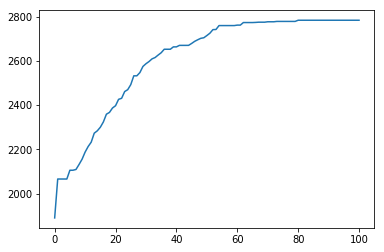

In [23]:
plt.plot(data['Fitness'])

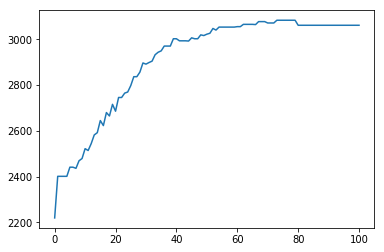

In [24]:
plt.plot(data['Population'])

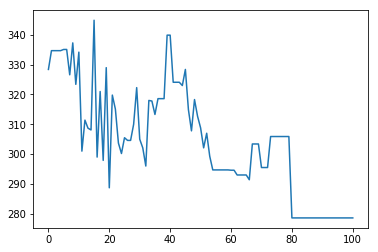

In [25]:
plt.plot(data['Distance'])

In [30]:
data.tail(1).values

array([[100.0,
        "('NAEQRTXJ', 'EAKTXDQN', 'NAEQRTXD', 'UDQENXTR', 'QSCANXEV', 'NAEQXYMD', 'UDQENXHT', 'NIXTUDQE', 'LDUGQNXB', 'TOFQWPNX')",
        2783.4, 3062.0, 278.6]], dtype=object)

In [ ]:
# dummy_population = [['BNXTQEAK', 'THNSXLDQ', 'QDXTUECN', 'QEXTFUIN', 'PNXTLDGQ', 'ENXTURDQ', 'ENXTURDQ', 'QEXTRLNU', 'DWXYQMNT', 'XQOEVJAN'],
#          ['QXDWNTOE', 'NSYETQXF', 'XQNETDUB', 'TXQJHNEL', 'EUNCVQXT', 'DLRNTQXU', 'UQNETXID', 'AERNDQXT', 'RXTNPQKM', 'LTGQDEXN']]

In [ ]:
dummy_population = [['BNXTQEAK', 'THNSXLDQ', 'QDXTUECN', 'QEXTFUIN', 'PNXTLDGQ'],
                    ['QXDWNTOE', 'NSYETQXF', 'XQNETDUB', 'TXQJHNEL', 'EUNCVQXT']]

In [ ]:

random.seed(143)
# inter_cross_off = []
#     print(len(population))
t = random.sample(set(map(tuple,dummy_population)),2)
for i in range(0,2,2):
    #parent1 
    p1_idx = i%2
    #parent2
    p2_idx = (i+1)%2
    cut_pt1 = random.randint(0,5)
    cut_pt2 = cut_pt1 + 10//2
    inter_off1 = t[p1_idx][0:cut_pt1] + t[p2_idx][cut_pt1:cut_pt2] + t[p1_idx][cut_pt2:]
    inter_off2 = t[p2_idx][0:cut_pt1] + t[p1_idx][cut_pt1:cut_pt2] + t[p2_idx][cut_pt2:]
#     inter_cross_off.append(list(inter_off1))
#     inter_cross_off.append(list(inter_off2))
    print(list(inter_off1))
    print(list(inter_off2))

In [ ]:
# def intra_crossover(m,max_nodes):
#     intra_cross_off = []
#     m = 3
for i in (dummy_population * 3):
    while True:
        t = list(i)
        r = random.sample(range(8),2)
#         print(rand_idx)
        temp_route1 = t[r[0]]
#         print(temp_route1)
        temp_route2 = t[r[1]]
#         print(temp_route2)
#             cut_pt1 = random.randint(1,4)
        cut_pt1 = random.randint(0,4) # allowing to change the first positioned city as well
#         print(cut_pt1)
        cut_pt2 = cut_pt1 + 8//2
        temp_route1 = t[r[0]][0:cut_pt1] + t[r[1]][cut_pt1:cut_pt2] + t[r[0]][cut_pt2:]
        temp_route2 = t[r[1]][0:cut_pt1] + t[r[0]][cut_pt1:cut_pt2] + t[r[1]][cut_pt2:]
        if non_repeat_nodes(temp_route1) and non_repeat_nodes(temp_route2):
            t[r[0]] = temp_route1
            t[r[1]] = temp_route2
            print(t)
#             print(t[r[0]])
#             print(t[r[1]])
            break
#     return intra_cross_off

In [22]:
# mutation
# def mutation(crossover_offspring,mutation_rate,max_nodes,ca_tsp):
#     mutated_offspring = []

for idx in range(len(dummy_population)):

    dummy_population[idx] = list(dummy_population[idx])
    for gene_num in range(len(dummy_population[idx])):
        if random.random() < 0.07:
            while True:
#                     mut_pt = random.randint(1,max_nodes-1)
                mut_pt = random.randint(0,8-1) # allowing to change the first positioned city as well
                temp = list(dummy_population[idx][gene_num])
                temp[mut_pt] = random.choice(list(ca_tsp.City))
                temp = ''.join(temp)
                if non_repeat_nodes(temp):
                    dummy_population[idx][gene_num] = temp
                    break
    print(dummy_population[idx])    
#     return mutated_offspring

NameError: name 'dummy_population' is not defined